In [1]:
module Lattice

import Base: show
using SparseArrays
import Plots

export AbstractLattice, Lattice, SquareLattice,
       Site, Link, LGTNotation,
       get_site, get_link, link_exists, link_index,
       get_connectivity_mat, dimension, num_sites, num_links,
       LGT_notation, vector, direction, plot

# ------------------------------------------------------------
# Abstract supertype
# ------------------------------------------------------------

"""
    AbstractLattice

Abstract supertype for all lattice-like objects.

Concrete subtypes must store a collection of sites and links and
implement (or forward) the basic lattice interface:

- `get_site`
- `get_link`
- `link_exists`
- `link_index`
- `get_connectivity_mat`
- `dimension`
- `num_sites`
- `num_links`
"""
abstract type AbstractLattice end

# ------------------------------------------------------------
# Core types: LGTNotation, Site, Link
# ------------------------------------------------------------

"""
    LGTNotation{N}(coords, direction)

Representation of a link in LGT (lattice gauge theory) notation.

Fields:
- `coordinates::NTuple{N,Int}` — coordinates of the starting site
- `direction::Int` — direction index (0 = +x, 1 = +y, ...)

Used to identify links by their starting point and direction.
"""
struct LGTNotation{N}
    coordinates::NTuple{N,Int}
    direction::Int
end

Base.:(==)(a::LGTNotation{N}, b::LGTNotation{N}) where {N} =
    a.coordinates == b.coordinates && a.direction == b.direction

"""
    Site(coords)

A lattice site with integer coordinates.

Fields:
- `coordinates::NTuple{N,Int}`
- `out_links::Vector{Link}`
- `in_links::Vector{Link}`

Use `dimension(site)` to get the spatial dimension.
"""
mutable struct Site{N}
    coordinates::NTuple{N,Int}
    out_links::Vector{Any}
    in_links::Vector{Any}
end

function Site(coords::AbstractVector{<:Integer})
    N = length(coords)
    Site{N}(NTuple{N,Int}(coords), Any[], Any[])
end

function show(io::IO, s::Site{N}) where {N}
    print(io, "<Site ", s.coordinates, ">")
end

"""
    dimension(site)

Return the spatial dimension of a site.
"""
dimension(s::Site{N}) where {N} = N

"""
    links(site)

Return all incoming and outgoing links attached to a site.
"""
links(s::Site) = vcat(s.in_links, s.out_links)

"""
    Link(a, b)

A directed link from site `a` to site `b`.

Automatically registers itself in `a.out_links` and `b.in_links`.
"""
mutable struct Link{N}
    sites::NTuple{2,Site{N}}
end

function Link(a::Site{N}, b::Site{N}) where {N}
    l = Link{N}((a, b))
    push!(a.out_links, l)
    push!(b.in_links, l)
    return l
end

function show(io::IO, l::Link{N}) where {N}
    print(io, "<Link ", l.sites[1], " → ", l.sites[2], ">")
end

"""
    vector(link)

Return the displacement vector from the starting site to the ending site.
"""
function vector(l::Link{N}) where {N}
    a = l.sites[1].coordinates
    b = l.sites[2].coordinates
    [b[i] - a[i] for i in 1:N]
end

"""
    direction(link)

Return the direction index of a link, assuming it is a positive unit vector
along a coordinate axis. Returns `nothing` otherwise.
"""
function direction(l::Link{N}) where {N}
    idx = vector_to_direction_index(vector(l))
    if idx === nothing
        @warn "direction is only defined for standard positive unit vectors"
        return nothing
    end
    return idx
end



"""
    LGT_notation(link)

Return the LGTNotation representation of a link.
"""
LGT_notation(l::Link{N}) where {N} =
    LGTNotation{N}(l.sites[1].coordinates, direction(l))

"""
    vector_to_direction_index(v)

Map a unit vector to a direction index.
Returns `nothing` if the vector is not a standard positive unit vector.
"""
function vector_to_direction_index(v::AbstractVector{<:Integer})
    N = length(v)
    if N == 1
        return v[1] == 1 ? 0 : nothing
    elseif N == 2
        return v == [1,0] ? 0 :
               v == [0,1] ? 1 : nothing
    elseif N == 3
        return v == [1,0,0] ? 0 :
               v == [0,1,0] ? 1 :
               v == [0,0,1] ? 2 : nothing
    else
        return nothing
    end
end

# ------------------------------------------------------------
# Generic Lattice type
# ------------------------------------------------------------

"""
    Lattice(sites, links)

Generic lattice container storing:
- `sites::Vector{Site}`
- `links::Vector{Link}`

This type is normally not constructed directly by the user.
Use `SquareLattice` or other specialized lattice constructors.
"""
mutable struct Lattice{N} <: AbstractLattice
    sites::Vector{Site{N}}
    links::Vector{Link{N}}
end

dimension(L::Lattice{N}) where {N} = N
num_sites(L::Lattice) = length(L.sites)
num_links(L::Lattice) = length(L.links)

# ------------------------------------------------------------
# Lookup helpers
# ------------------------------------------------------------

_coords_tuple(::Val{N}, coords) where {N} = NTuple{N,Int}(coords)

"""
    get_site(L, coords; n=1)

Return the site at the given coordinates.

- `coords` may be a Vector, Tuple, or NTuple.
- If `n > 1`, return up to `n` matching sites.
"""
function get_site(L::Lattice{N}, coords; n::Int=1) where {N}
    c = _coords_tuple(Val(N), coords)
    found = [s for s in L.sites if s.coordinates == c]
    isempty(found) && error("no site with coordinates $coords")
    return n > 1 ? found[1:min(n, end)] : found[1]
end

"""
    get_link(L, a, b; n=1)
    get_link(L, coords, dir; n=1)

Return a link either by:
- two site objects `a → b`, or
- LGT notation `(coords, direction)`.

If `n > 1`, return up to `n` matches.
"""
function get_link(L::Lattice{N}, a::Site{N}, b::Site{N}; n::Int=1) where {N}
    found = [lk for lk in L.links if lk.sites == (a, b)]
    isempty(found) && error("no link from $a to $b")
    return n > 1 ? found[1:min(n, end)] : found[1]
end

function get_link(L::Lattice{N}, coords, dir::Int; n::Int=1) where {N}
    c = _coords_tuple(Val(N), coords)
    target = LGTNotation{N}(c, dir)
    found = [lk for lk in L.links if LGT_notation(lk) == target]
    isempty(found) && error("no link with LGT notation (coords=$coords, dir=$dir)")
    return n > 1 ? found[1:min(n, end)] : found[1]
end

"""
    link_index(L, link)
    link_index(L, a, b)

Return the index of a link in `L.links`.
"""
link_index(L::Lattice, lk::Link) = findfirst(==(lk), L.links) -1

function link_index(L::Lattice{N}, a::Site{N}, b::Site{N}) where {N}
    lk = get_link(L, a, b)
    link_index(L, lk)
end

function link_index(L::Lattice{N}, coords, dir::Int) where {N}
    lk = get_link(L, coords, dir)
    return link_index(L, lk)
end


"""
    link_exists(L, args...)

Return `true` if a link exists, `false` otherwise.

Accepts either:
- `(Site, Site)`
- `(coords, direction)`
"""
function link_exists(L::Lattice, args...)
    try
        get_link(L, args...)
        return true
    catch
        return false
    end
end

# """
#     link_exists(L, coords, dir)

# Return true if a link starting at `coords` in direction `dir` exists.
# Supports LGT notation: (coords, dir).
# """
# function link_exists(L::Lattice{N}, coords, dir::Int) where {N}
#     # Normalize coordinates
#     c = try
#         NTuple{N,Int}(coords)
#     catch
#         return false
#     end

#     # Compute target coordinates
#     unit = ntuple(i -> (i == dir+1 ? 1 : 0), N)
#     target = ntuple(i -> c[i] + unit[i], N)

#     # Check if the link actually exists in L.links
#     for lk in L.links
#         if lk.sites[1].coordinates == c &&
#            lk.sites[2].coordinates == target
#             return true
#         end
#     end

#     return false
# end

# ------------------------------------------------------------
# Connectivity matrix
# ------------------------------------------------------------

"""
    get_connectivity_mat(L)

Return a sparse adjacency matrix `A` where `A[i,j] = 1`
if there is a directed link from site `i` to site `j`.

Site ordering follows `L.sites`.
"""
function get_connectivity_mat(L::Lattice{N}) where {N}
    ns = num_sites(L)
    coord_to_idx = Dict(s.coordinates => i for (i,s) in enumerate(L.sites))

    rows = Int[]
    cols = Int[]
    vals = Int[]
    for lk in L.links
        i = coord_to_idx[lk.sites[1].coordinates]
        j = coord_to_idx[lk.sites[2].coordinates]
        push!(rows, i); push!(cols, j); push!(vals, 1)
    end

    sparse(rows, cols, vals, ns, ns)
end

# ------------------------------------------------------------
# Plotting (2D)
# ------------------------------------------------------------

"""
    plot(L)

Plot a 2D lattice using Plots.jl.
"""
function plot(L::Lattice{2})
    xs = [s.coordinates[1] for s in L.sites]
    ys = [s.coordinates[2] for s in L.sites]
    p = Plots.scatter(xs, ys, legend=false)
    for lk in L.links
        x1,y1 = lk.sites[1].coordinates
        x2,y2 = lk.sites[2].coordinates
        Plots.plot!([x1,x2], [y1,y2], color=:black, lw=2)
    end
    display(p)
end

plot(L::Lattice) = println("Plotting is only implemented for 2D lattices.")

# ------------------------------------------------------------
# SquareLattice subtype with OO-style bound methods
# ------------------------------------------------------------

"""
    SquareLattice(dim, size)

Construct a hypercubic lattice of dimension `dim`.

Arguments:
- `dim::Int` — spatial dimension
- `size` — either an integer (same size in all directions)
           or an iterable of length `dim`

Creates:
- all sites with integer coordinates in `[0:size_i-1]`
- links in all positive unit directions

Provides both:
- free functions (`get_site(S, ...)`)
- OO-style methods (`S.get_site(...)`)
"""
mutable struct SquareLattice{N} <: AbstractLattice
    lattice::Lattice{N}
    size::NTuple{N,Int}

    # OO-style bound methods
    get_site
    get_link
    link_exists
    link_index
    get_connectivity_mat
    plot
end

dimension(S::SquareLattice{N}) where {N} = N
num_sites(S::SquareLattice) = num_sites(S.lattice)
num_links(S::SquareLattice) = num_links(S.lattice)

# Free-function forwarding
get_site(S::SquareLattice, args...; kwargs...) = get_site(S.lattice, args...; kwargs...)
get_link(S::SquareLattice, args...; kwargs...) = get_link(S.lattice, args...; kwargs...)
link_exists(S::SquareLattice, args...) = link_exists(S.lattice, args...)
link_index(S::SquareLattice, args...) = link_index(S.lattice, args...)
get_connectivity_mat(S::SquareLattice) = get_connectivity_mat(S.lattice)
plot(S::SquareLattice{2}) = plot(S.lattice)

# function SquareLattice(dim::Int, size; periodic::Bool=false)
#     sizes = isa(size, Int) ? ntuple(_ -> size, dim) : Tuple(size)
#     ranges = [0:(sizes[i]-1) for i in 1:dim]

#     # create sites
#     sites = Site{dim}[]
#     for coords in Iterators.product(ranges...)
#         push!(sites, Site(collect(coords)))
#     end

#     # create lattice container
#     L = Lattice{dim}(sites, Link{dim}[])

#     # unit vectors for positive directions
#     unit_vecs = [[i==j ? 1 : 0 for j in 1:dim] for i in 1:dim]

#     # create links (positive directions, with optional PBC)
#     for s in L.sites
#         for u in unit_vecs
#             # candidate neighbor
#             next_coords = [s.coordinates[i] + u[i] for i in 1:dim]

#             if periodic
#                 # wrap each coordinate modulo lattice size
#                 next_coords = [(next_coords[i] % sizes[i]) for i in 1:dim]
#             end

#             try
#                 ns = get_site(L, next_coords)
#                 push!(L.links, Link(s, ns))
#             catch
#                 # if not periodic and out of bounds: skip
#             end
#         end
#     end

#     return SquareLattice{dim}(
#         L,
#         sizes,
#         (args...; kwargs...) -> get_site(L, args...; kwargs...),
#         (args...; kwargs...) -> get_link(L, args...; kwargs...),
#         (args...) -> link_exists(L, args...),
#         (args...) -> link_index(L, args...),
#         () -> get_connectivity_mat(L),
#         () -> plot(L)
#     )
# end


function SquareLattice(dim::Int, size)
    sizes = isa(size, Int) ? ntuple(_ -> size, dim) : Tuple(size)
    ranges = [0:(sizes[i]-1) for i in 1:dim]

    # create sites
    sites = Site{dim}[]
    for coords in Iterators.product(ranges...)
        push!(sites, Site(collect(coords)))
    end

    # create lattice container
    L = Lattice{dim}(sites, Link{dim}[])

    # create links (positive directions)
    unit_vecs = [[i==j ? 1 : 0 for j in 1:dim] for i in 1:dim]

    for s in L.sites
        for u in unit_vecs
            next_coords = [s.coordinates[i] + u[i] for i in 1:dim]
            try
                ns = get_site(L, next_coords)
                push!(L.links, Link(s, ns))
            catch
            end
        end
    end

    # OO-style bound methods
    return SquareLattice{dim}(
        L,
        sizes,
        (args...; kwargs...) -> get_site(L, args...; kwargs...),
        (args...; kwargs...) -> get_link(L, args...; kwargs...),
        (args...) -> link_exists(L, args...),
        (args...) -> link_index(L, args...),
        () -> get_connectivity_mat(L),
        () -> plot(L)
    )
end

end # module

Main.Lattice

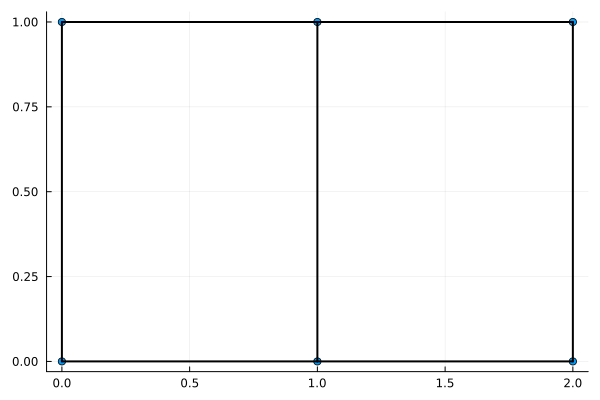

In [2]:
using .Lattice

lat = Lattice.SquareLattice(2, [3,2])
lat.plot()




In [3]:
module QOUtils

using QuantumOptics

"""
    tensor_op(obj, default_obj, index, N)

Embed a single operator `obj` into an N-partite tensor product,
placing it at position `index` (0-based), using `default_obj` on all others.
"""
function tensor_op(obj, default_obj, index::Int, N::Int)
    if index < 0 || index >= N
        error("tensor_op: index=$index is out of range for N=$N")
    end
    ops = Any[deepcopy(default_obj) for _ in 1:N]
    ops[index+1] = obj
    return tensor(ops...)
end

"""
    tensor_op_sim(objs, default_obj, indices, N)

Embed several operators `objs` into an N-partite tensor product.
`indices` are 0-based positions of each operator.
"""
function tensor_op_sim(objs::Vector, default_obj, indices::Vector{Int}, N::Int)
    ops = Any[deepcopy(default_obj) for _ in 1:N]
    for (pos, ind) in enumerate(indices)
        if ind < 0 || ind >= N
            error("tensor_op_sim: index=$ind is out of range for N=$N")
        end
        ops[ind+1] = objs[pos]
    end
    return tensor(ops...)
end

end # module

Main.QOUtils

In [4]:
using QuantumOptics
using .QOUtils

# Define a qubit basis
b = SpinBasis(1//2)

sx = sigmax(b)
sz = sigmaz(b)
id = identityoperator(b)

# Example: put σx on site 1 of a 4-site system
op1 = QOUtils.tensor_op(sx, id, 1, 4)

# Example: put σx on site 0 and σz on site 2
op2 = QOUtils.tensor_op_sim([sx, sz], id, [0, 2], 4)

Operator(dim=16x16)
  basis: [Spin(1/2) ⊗ Spin(1/2) ⊗ Spin(1/2) ⊗ Spin(1/2)]
⎡⠊⡠⠀⠀⠀⠀⠀⠀⎤
⎢⠀⠀⠊⡠⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠊⡠⠀⠀⎥
⎣⠀⠀⠀⠀⠀⠀⠊⡠⎦

In [5]:
module LatticeOps

using QuantumOptics
using ..QOUtils
using ..Lattice

"""
    make_link_operator(lat, n, default_obj)

Return a function `op(qobj, linkargs)` that embeds a local operator `qobj`
into the global Hilbert space of `n` links, placed on the link specified
by `linkargs`.

`linkargs` can be either:
- `(coords, dir)`  where `coords` is a coordinate tuple or vector, and `dir` is an Int
- `(site1, site2)` two `Site` objects

If the link does not exist in `lat`, the global identity is returned.
"""
function make_link_operator(lat::AbstractLattice, n::Int, id_local; default_obj=id_local)
    # Build global identity as tensor product of `n` copies of default_obj
    ops = Any[deepcopy(id_local) for _ in 1:n]
    Id_global = tensor(ops...)

    return function (qobj, linkargs)
        if lat.link_exists(linkargs...)
            idx = lat.link_index(linkargs...)
            return QOUtils.tensor_op(qobj, default_obj, idx, n)
        else
            return Id_global
        end
    end
end

end # module

Main.LatticeOps

In [6]:
using QuantumOptics
using .QOUtils
using .Lattice
using .LatticeOps
# Build a lattice
lat = Lattice.SquareLattice(2, [2,3])   # for example
n = Lattice.num_links(lat)

# Define a local Hilbert space
b = SpinBasis(1//2)
id_local = identityoperator(b)

# Build the operator factory
op = LatticeOps.make_link_operator(lat, n, id_local)

# Now use it exactly like Python
σx = sigmax(b)

# Example: operator on link with LGT notation ([x,y], dir)
A = op(σx, ((0,0), 0))

# Example: operator on link between two sites
s1 = Lattice.get_site(lat, (0,0))
s2 = Lattice.get_site(lat, (1,0))
B = op(σx, (s1, s2))
A


Operator(dim=128x128)
  basis: [Spin(1/2) ⊗ Spin(1/2) ⊗ Spin(1/2) ⊗ Spin(1/2) ⊗ Spin(1/2) ⊗ Spin(1/2) ⊗ Spin(1/2)]
⎡⠪⡢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎤
⎢⠀⠀⠡⡢⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠈⠐⡠⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠈⠊⠄⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠈⠪⢂⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠪⡢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠡⡢⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠐⠄⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠊⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠪⢂⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠡⡢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⡠⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠐⠄⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠪⢂⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠪⡢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠡⡢⡀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠐⡠⡀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠊⠄⡀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠪⢂⠀⠀⎥
⎣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠪⡢⎦

In [7]:
############################
# exact Hamiltonian (Julia)
############################

using QuantumOptics
using .Lattice
using .QOUtils
using .LatticeOps

lat = Lattice.SquareLattice(2, [3,2]) 

Nx = lat.size[1]
Ny = lat.size[2]

rangex = range(0,Nx-1)
rangey = range(0,Ny-1)

# # add u and l bound links
# for i in range(1,Nx-2)
#     push!(lat.lattice.sites, Lattice.Site([i,Ny]))
#     push!(lat.lattice.links, Lattice.Link(lat.get_site((i,Ny-1)), lat.get_site((i,Ny))))
#     push!(lat.lattice.sites, Lattice.Site([i,-1]))
#     push!(lat.lattice.links, Lattice.Link(lat.get_site((i,-1)), lat.get_site((i,0))))
# end


J = 1
lam_B = 0
lam_E = 0
m = 0

descriptor = "($(lat.size[1]) x $(lat.size[2]) sites, J=$(J), m=$m, \\lambda_B=$lam_B, \\lambda_E=$lam_E"


# Local Hilbert space
b = SpinBasis(1//2)
id_local = identityoperator(b)
sig = [sigmax(b), sigmay(b), sigmaz(b)]

# Number of links
n = Lattice.num_links(lat)

# Global identity on all links
Id = begin
    ops = Any[deepcopy(id_local) for _ in 1:n]
    tensor(ops...)
end

# Operator factory (same semantics as Python)
op = LatticeOps.make_link_operator(lat, n, id_local)

# Convenience wrappers
X(args...) = op(sigmax(b), args)
Y(args...) = op(sigmay(b), args)
Z(args...) = op(sigmaz(b), args)


########################################
# HB term
########################################

function HB(lam_B)
    # zero operator on full Hilbert space
    H = zero(Id)

    # plaquette labeled by bottom-left site
    for i in 0:(Nx-1)
        for j in 0:(Ny-1)
            H +=  Y((i,j), 0) *
                  Y((i+1,j), 1) *
                  X((i,j), 1) *
                  X((i,j+1), 0) *
                  Z((i-1,j+1), 0) *
                  Z((i,j+1), 1)
        end
    end

    return -lam_B * H
end


########################################
# Hm term
########################################

function Hm(m)
    H = zero(Id)

    # plaquette labeled by bottom-left site
    for i in 0:(Nx-2)
        for j in 0:(Ny-2)
            H +=  Z((i,j), 0) *
                  Z((i,j), 1) *
                  Z((i-1,j), 0) *
                  Z((i,j-1), 1)
        end
    end

    return -(m/2) * H
end


########################################
# HE term
########################################

function HE(lam_E)
    H = zero(Id)

    for (idx, l) in enumerate(lat.lattice.links)
        # same as Python: tensor_op(sigmaz, identity, link_index, n)
        H += QOUtils.tensor_op(sigmaz(b), id_local, idx-1, n)
    end

    return lam_E * H
end


########################################
# Hint term
########################################

function Hint(J)
    H = zero(Id)

    # bulk
    for i in rangex
        for j in rangey

            if lat.link_exists((i,j), 0)
                # horizontal 2-body
                # H += Y((i,j),0) * Z((i+1,j-1),1)

                # horizontal 6-body
                H +=  Y((i,j), 0) *
                      Z((i,j-1), 1) *
                      Z((i-1,j), 0) *
                      Z((i,j), 1) *
                      Z((i+1,j), 1) *
                      Z((i+1,j), 0)
            end

            if lat.link_exists((i,j), 1)
                # vertical two-body
                H += Y((i,j),1) * Z((i,j),0)

                # vertical 6-body
                # H += Y((i,j),1) * Z((i,j-1),1) * Z((i-1,j),0) *
                #      Z((i-1,j+1),0) * Z((i,j+1),1) * Z((i,j+1),0)
            end

        end
    end

    return (J/2) * H
end

J = 1
lam_B = 0
lam_E = 0
m = 0

H = Hint(J)



Operator(dim=128x128)
  basis: [Spin(1/2) ⊗ Spin(1/2) ⊗ Spin(1/2) ⊗ Spin(1/2) ⊗ Spin(1/2) ⊗ Spin(1/2) ⊗ Spin(1/2)]
⎡⢮⡳⡎⠢⡀⠑⢄⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠓⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎤
⎢⠪⡉⢡⡲⣬⠀⠀⠑⢄⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠱⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⢄⠈⠂⠛⠚⡠⣄⡠⡀⠑⠀⠀⠀⠀⠑⣄⠀⠀⠀⠀⠀⠀⠀⠀⠑⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠑⢄⠀⠀⡹⠮⠇⣈⠢⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠱⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠑⢄⠈⠢⡘⣮⣻⠀⠀⠀⠀⠀⠀⠀⠈⠑⢄⠀⠀⠀⠀⠀⠀⠀⠈⠑⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⢮⡳⡎⠢⡀⠓⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠓⢄⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠪⡉⢡⡲⣬⠀⠀⠱⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠱⢄⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠑⢤⠀⠀⠀⠀⢤⠈⠂⠛⠚⡤⡤⡠⡀⠑⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠓⢄⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠑⢄⡀⠀⠀⠑⢄⡀⠀⡫⠮⢇⣈⡢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠱⢄⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠑⢄⠈⠢⡸⣪⣺⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⣄⎥
⎢⠙⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡯⡫⡎⠢⡀⠑⢄⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠑⢆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠪⡉⢱⡲⣪⠀⠈⠑⢄⠀⠀⠈⠑⢄⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠑⢤⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢄⠈⠊⠚⠚⡤⣤⠠⡀⠓⠀⠀⠀⠀⠓⢄⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠑⢆⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢆⠀⠀⡛⠮⢃⣈⡢⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠑⢤⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢤⠈⠢⡸⢮⡳⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢄⡀⠀⠀⠀⠀⠀⠀⠀⠑⢄⡀⠀⠀⠀⠀⠀⠀⠀⣯⡻⡌⠢⡀⠑⢄⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢆⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠢⡉⢰⡲⣎⠀⠀⠑⢄⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢄⠀⠀⠀⠀⠀⠀⠀⠀⠙⢄⠀⠀⠀⠀⢄⠈⠊⠙⠊⡤⣤⠠⡀⠑⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢆⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠑⢄⠀⠀⡛⠮⢃⣈⡢⎥
⎣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢤⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠑⢄⠈⠢⡸⢮⡳⎦

In [8]:
########################
# Trotterization (Julia)
########################

# sig = [sigmax(b), sigmay(b), sigmaz(b)]  # assumed already defined
# Id  = global identity on all links
# op  = make_link_operator(...)

# U(a,b,l1,l2):
# if one of the two links is not in the lattice, return Id
function U(a, b, l1, l2)
    if op(sig[a+1], l2) == Id || op(sig[b+1], l1) == Id
        return Id
    else
        return 0.5 * (Id +
                      op(sig[a+1], l2) +
                      op(sig[b+1], l1) -
                      op(sig[a+1], l2) * op(sig[b+1], l1))
    end
end

# ZiX(l1,l2, add_vertical=False):
# if one of the two links is not in the lattice, return Id
function ZiX(l1, l2; add_vertical=false)
    if op(sig[3], l2) == Id || op(sig[1], l1) == Id
        return Id
    else
        return 0.5 * (Id +
                      op(sig[3], l2) +
                      im * op(sig[1], l1) -
                      im * op(sig[3], l2) * op(sig[1], l1))
    end
end

# Single-link rotations
function RX(theta, link)
    return op(exp(-im * theta/2 * sigmax(b)), link)
end

function RY(theta, link)
    return op(exp(-im * theta/2 * sigmay(b)), link)
end

function RZ(theta, link)
    return op(exp(-im * theta/2 * sigmaz(b)), link)
end

RZ (generic function with 1 method)

In [9]:
function trotter_step_E_J(dt)
    trotter = [Id for _ in 1:30]
    trotter_all = Id
    shift = 15

    ## 1
    for i in rangex
        for j in rangey
            if isodd(i) # odd column
                trotter[1] = trotter[1] * RZ(2 * dt * lam_E, ((i,j), 0))
                trotter[1] = trotter[1] * RZ(2 * dt * lam_E, ((i,j), 1))
                # trotter[1+shift] = trotter[1+shift] * RZ(2 * dt * lam_E, hor2ver(([i,j],0)))
                # trotter[1+shift] = trotter[1+shift] * RZ(2 * dt * lam_E, hor2ver(([i,j],1)))
            else
                trotter[1] = trotter[1] * U(2, 2, ((i,j), 0), ((i,j), 1))
                # trotter[1+shift] = trotter[1+shift] * U(2,2,hor2ver(([i,j],0)), hor2ver(([i,j],1)))
                # if j==Ny-1:
                #     trotter[0] * trotter[0] * U(2,2, ([i-1,j],0), ([i,j-1],1)) * U(2,1, ([i,j],0), ([i,j-1],1))
            end
        end
    end

    ## 2
    for i in rangex
        for j in rangey
            if isodd(i) # odd column
                trotter[2] = trotter[2] * U(2, 1, ((i,j), 0), ((i,j), 1))
                # trotter[2+shift] = trotter[2+shift] * U(2,1,hor2ver(([i,j],0)), hor2ver(([i,j],1)))
            else # even column
                trotter[2] = trotter[2] * RY(dt * J, ((i,j), 1))
                # trotter[2+shift] = trotter[2+shift] * RY( dt * J, hor2ver(([i,j],1)))
            end
        end
    end

    ## 3
    for i in rangex
        for j in rangey
            if isodd(i) # odd column
                trotter[3] = trotter[3] * U(2, 2, ((i-1,j), 0), ((i,j), 1))
                # trotter[3+shift] = trotter[3+shift] * U(2,2,hor2ver(([i-1,j],0)), hor2ver(([i,j],1)))
            else # even column
                trotter[3] = trotter[3] * U(2, 1, ((i-1,j), 0), ((i,j-1), 1))
                # trotter[3+shift] = trotter[3+shift] * U(2,1,hor2ver(([i-1,j],0)), hor2ver(([i,j-1],1)))
            end
        end
    end

    ## 4
    for i in rangex
        for j in rangey
            if isodd(i) # odd column
                # if j==Ny-1:
                #     trotter[4] = trotter[4] * U(2,1,([i,j],0), ([i,j-1],1))
                nothing
            else # even column
                trotter[4] = trotter[4] * U(2, 2, ((i,j-1), 1), ((i,j), 0))
                # trotter[4+shift] = trotter[4+shift] * U(2,2,hor2ver(([i,j-1],1)), hor2ver(([i,j],0)))
            end
        end
    end

    ## 5
    for i in rangex
        for j in rangey
            if isodd(i) # odd column
                nothing
            else # even column
                trotter[5] = trotter[5] * RY(dt * J, ((i,j), 0))
                # trotter[5+shift] = trotter[5+shift] * RY(dt * J, hor2ver(([i,j],0)))
            end
        end
    end

    ## 6
    trotter[6] = dagger(trotter[4])
    # trotter[6+shift] = trotter[4+shift].dag()

    ## 7
    trotter[7] = dagger(trotter[3])
    # trotter[7+shift] = trotter[3+shift].dag()

    ## 8
    # here there is a bit of uncertainty
    for i in rangex
        for j in rangey
            if isodd(i) # odd column
                # pass
                trotter[8] = trotter[8] * dagger(ZiX(((i,j), 0), ((i,j), 1)))
                # trotter[7] = trotter[7]*U(2,2, ([i+1,j],1),([i,j+1],1))
                # trotter[7+shift] = trotter[7+shift]*ZiX(hor2ver(([i,j],0)),hor2ver(([i,j],1))).dag()
            else # even column
                # pass
                trotter[8] = trotter[8] * ZiX(((i,j), 0), ((i,j), 1))
                # trotter[7+shift] = trotter[7+shift]*ZiX(hor2ver(([i,j],0)),hor2ver(([i,j],1)))
            end
        end
    end

    ## 9
    for i in rangex
        for j in rangey
            if isodd(i) # odd column
                trotter[9] = trotter[9] * U(2, 1, ((i-1,j), 0), ((i,j-1), 1))
                # trotter[9+shift] = trotter[9+shift] * U(2,1, hor2ver(([i-1,j],0)),hor2ver(([i,j-1],1)))
            else # even column
                trotter[9] = trotter[9] * U(2, 2, ((i-1,j), 0), ((i,j), 1))
                # trotter[9+shift] = trotter[9+shift] * U(2,2, hor2ver(([i-1,j],0)),hor2ver(([i,j],1)))
            end
        end
    end

    ## 10
    for i in rangex
        for j in rangey
            if isodd(i) # odd column
                trotter[10] = trotter[10] * U(2, 2, ((i,j-1), 1), ((i,j), 0))
                # trotter[10+shift] = trotter[10+shift] * U(2,2,hor2ver(([i,j-1],1)), hor2ver(([i,j],0)))
            else # even column
                nothing
            end
        end
    end

    ## 11
    for i in rangex
        for j in rangey
            if isodd(i) # odd column
                trotter[11] = trotter[11] * RY(dt * J, ((i,j), 0))
                # trotter[11+shift] = trotter[11+shift] * RY(dt * J, hor2ver(([i,j],0)))
            else # even column
                nothing
            end
        end
    end

    ## 12
    trotter[12] = dagger(trotter[10])
    # trotter[12+shift] = trotter[10+shift].dag()

    ## 13
    trotter[13] = dagger(trotter[9])
    # trotter[13+shift] = trotter[9+shift].dag()

    ## 14
    for i in rangex
        for j in rangey
            if isodd(i) # odd column
                trotter[14] = trotter[14] * RY(dt * J, ((i,j), 1))
                # trotter[14+shift] = trotter[14+shift] * RY(dt * J, hor2ver(([i,j],1)))
            else # even column
                trotter[14] = trotter[14] * U(2, 1, ((i,j), 0), ((i,j), 1))
                # trotter[14+shift] = trotter[14+shift] * U(2,1,hor2ver(([i,j],0)), hor2ver(([i,j],1)))
            end
        end
    end

    ## 15
    for i in rangex
        for j in rangey
            if isodd(i) # odd column
                trotter[15] = trotter[15] * U(2, 2, ((i,j), 0), ((i,j), 1))
                # trotter[15+shift] = trotter[15+shift] * U(2,2,hor2ver(([i,j],0)), hor2ver(([i,j],1)))
            else # even column
                trotter[15] = trotter[15] * RZ(2 * dt * lam_E, ((i,j), 0))
                trotter[15] = trotter[15] * RZ(2 * dt * lam_E, ((i,j), 1))
            end
        end
    end

    # Multiply all layers
    for op_ in trotter
        trotter_all = op_ * trotter_all
    end

    return trotter_all
end

trotter_step_E_J (generic function with 1 method)

In [10]:
using LinearAlgebra
using CairoMakie

###############################
# Exact time evolution
###############################

T = 1.0

# Exact propagator: exp(-i T H)
prop = exp(-im * T * H)

err_sum = Float64[]
n_trotter_range = collect(50:80:1000)
# n_trotter_range = [200]
for n_trotter in n_trotter_range
    dt = T / n_trotter

    # One Trotter step
    tr = trotter_step_E_J(dt)
    
    # Apply it n_trotter times
    t = @elapsed begin
        tr = trotter_step_E_J(dt)
        prop_tr = tr^n_trotter
    end
    println(t)
    # Convert to dense matrices
    M_exact = Matrix(prop.data)
    M_trot  = Matrix(prop_tr.data)

    # Error matrix
    err = abs.(M_exact .- M_trot)

    # Normalized error
    push!(err_sum, sum(err) / sum(abs.(M_exact)))
end



0.1211292
0.0275969
0.0180568
0.0199129
0.0227498
0.0264726
0.0209499
0.026836
0.0286742
0.0193428
0.0240101
0.0232004


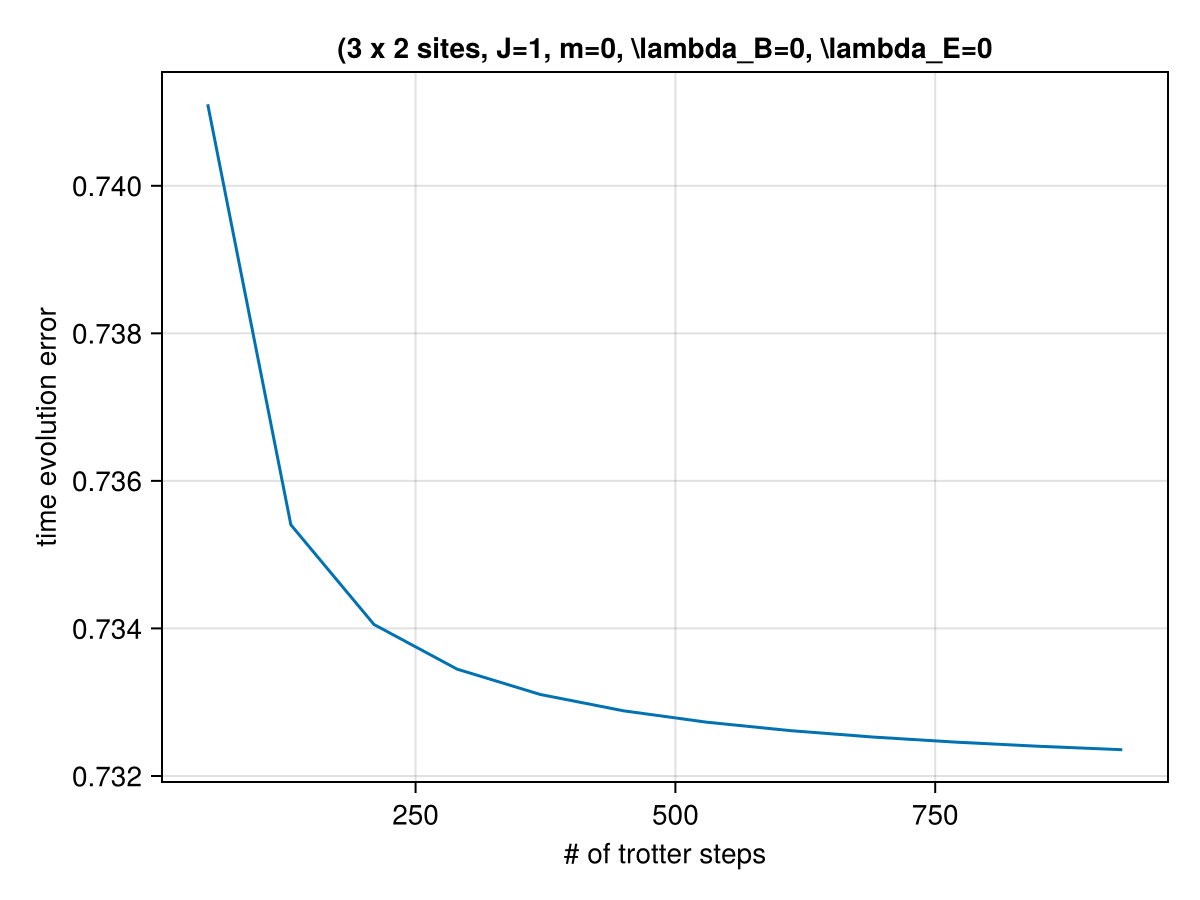

In [11]:
fig4 = Figure()
ax4 = Axis(fig4[1,1],
    xlabel="# of trotter steps",
    ylabel="time evolution error",
    title= descriptor
)

lines!(ax4, n_trotter_range, err_sum)
fig4


In [12]:
n

7